# Dear Evaluator,
#### This exercise was designed such that global constant values in the ex8.py file had to change based on each task (each of the cells) below. The current ex8.py file in our submission is in accordance with task 4 (last cell of this notebook). Thus, if you run the prior cells, you will not obtain the results recorded as documentation in this notebook. Kindly evaluate the cells as-are if you want to avoid drastic errors. This whole thing is because variables such as delta_max, v_max, proportional, derivative, and integral gains have been defined as global variables in ex8.py by the assignment designer. Since I started the first and second task using that configuration, it would have been cumbersome to go back and change it.

# Exercise 8 - Robot Control 

In this assignment, you will implement a controller for a car-like robot to follow a desired path. The controller has two components, (i) Longitudinal Controller and (ii) Lateral Controller. Your task is to implement the two controllers individually and then combine them to perform the task of path following.  



## Simplified Ackermann / Bicycle Model

For this assignment, we will consider the simplified Ackermann model (or Bicycle model) for describing the kinematics of a car-like robot. The state of the car is described by $[x, y, \theta, v, \delta]$ where $x,y$ is the position, $\theta$ is the orientation, $v$ is the linear velocity, and $\delta$ is the steering angle of the vehicle. The controls $u$ are given by the $[a, \dot{\delta}]$ where $a$ is the linear acceleration and $\dot{\delta}$ is the steering rate of the vehicle.

<img src="ackermann_car_model.png" width="500">

In order for the wheels of the car to have rolling motion without any slipping, the steering angle must be $\delta = \tan^{-1}(\frac{d}{r})$. Here, $d$ is the distance between the rear and the front axle of the car (i.e. length of the vehicle) and $r$ is the distance to the instantaneous center of curvature (ICC). In addition, our robot must satisfy the following constraints:
1. $ v < 10 \,m/s $ 
2. $ |\delta| \leq \pi/3 \,rad\,(60\,deg)$
3. $ |\dot{\delta}|  \leq 0.175\,rad/s\,(10\,deg/sec)$



In [1]:
import ex8 as ex
import numpy as np
import matplotlib.pyplot as plt
import math

# Initialze robot 
robot = ex.Robot()
robot.x = 1
robot.y = 3
robot.theta = np.pi/3
robot.v = 0
robot.delta = 0

# Pose of the robot before applying the control command
print('x:{:.2f}, y:{:.2f}, theta:{:.2f}, v:{:.2f}, delta:{:.2f}'.format(robot.x, robot.y, robot.theta, robot.v, robot.delta))

# Apply a control command
a = 1 # m/s
delta_dot = 0.1 # rad/s
dt = 1 #time period for which the command is applied
robot.apply_control(a, delta_dot, dt)

# Pose of the robot after applying the control command
print('x:{:.2f}, y:{:.2f}, theta:{:.2f}, v:{:.2f}, delta:{:.2f}'.format(robot.x, robot.y, robot.theta, robot.v, robot.delta))

x:1.00, y:3.00, theta:1.05, v:0.00, delta:0.00
x:1.50, y:3.87, theta:1.15, v:1.00, delta:0.10


## 8.1 Longitudinal Controller [6.0]

The goal of the longitudinal controller is ensure that the linear velocity $v$ of the vehicle is close to the desired velocity $v_{des}$. 

The robot follows velocity model that is linear in the control input $a$.

Implement a PID controller with appropriate gains $(K_P, K_D, K_I)$ such that $ |v - v_{des}| < 0.2\,m/s $ after intial convergence. 

Verify that your implementation is correct for some test input.

Hints:
1. Start with noise free control (by setting noisy_controls = False).
2. Tune the gains incrementally, i.e first set only $K_p$, then ($K_p,K_d$), and finally $(K_p, K_d, K_I)$.     

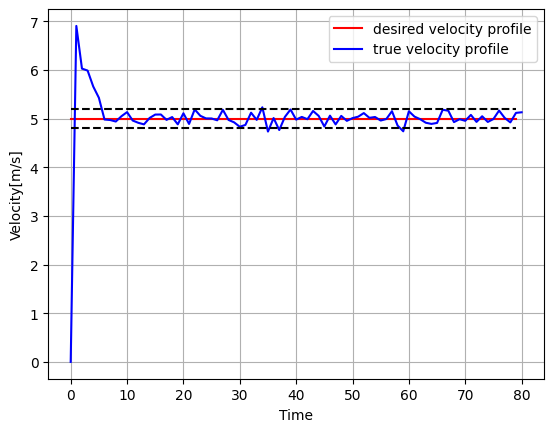

In [2]:
# Add code to test the PID controller

# initialize robot
robot = ex.Robot()
robot.x = 0
robot.y = 0
robot.theta = 0
robot.v = 0
robot.delta = 0


# robot constraints
v_max = 10
delta_max = np.pi/3
delta_dot_max = 0.175

# define the desired velocity, its limits and other needed variables
v_des_profile = 5*np.ones(80)
vel_high_lim  = v_des_profile + 0.2
vel_low_lim = v_des_profile - 0.2
v_true_profile = [robot.v]
delta_dot = 0
dt = 2

for i in range(len(v_des_profile)):
        
    # compute longitudinal control
    a_control = ex.longitudinal_controller(v_true_profile[i], v_des_profile[i], dt)

    # execute control action
    robot.apply_control(a_control, delta_dot, dt)
    
    # update v_true_profile
    v_true_profile.append(robot.v)


# Plot trajectory
plt.cla()
plt.plot(v_des_profile,"-r", label="desired velocity profile")
plt.plot(v_true_profile, "-b", label="true velocity profile")
plt.plot(vel_high_lim, "--k")
plt.plot(vel_low_lim, "--k")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Velocity[m/s]")
plt.grid(True)
plt.show()


### To be honest, use of integral controller in this case makes no sense. Integral controllers are best suited to gradually decease steady-steate steady error, i.e. a constant offset. The kind of error we're witnessing here is not a constant offset. It's a random fluctuation that changes direction and magnitude completely randomly. The PD controller is the best option.

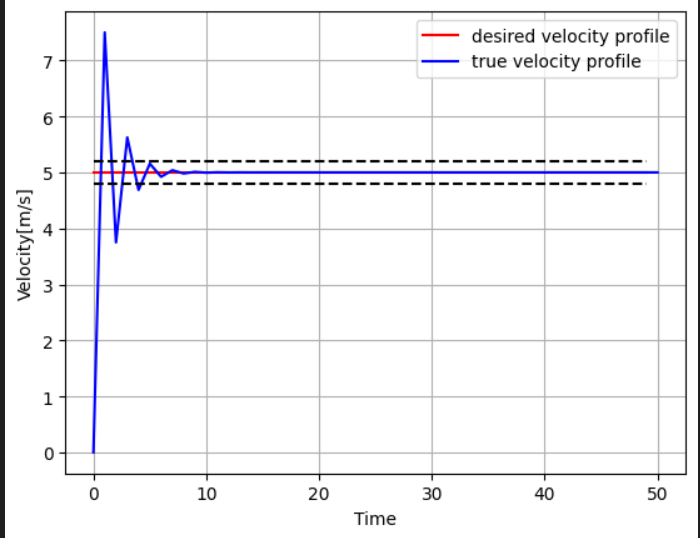
### Kp = 0.3,
### Kd = Ki = 0
### No dampling (derivative) and thus big overshoot

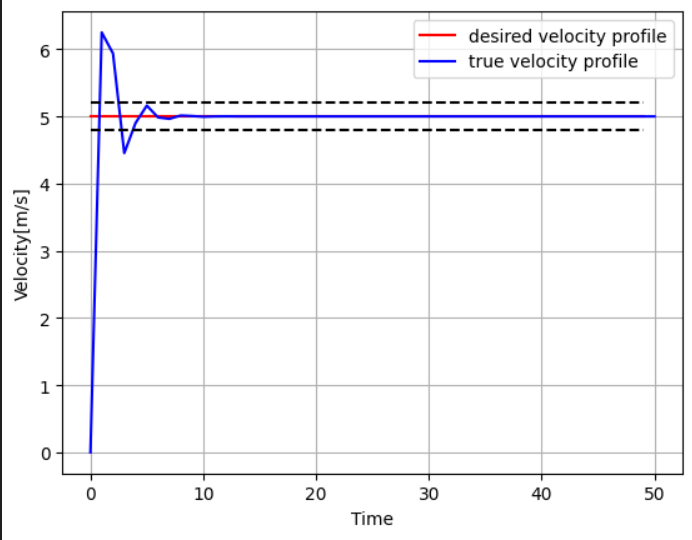
### Kp = 0.3, Kd = -0.25, Ki = 0
### Damping added. Overshoot is smaller and vanishes more quickly.

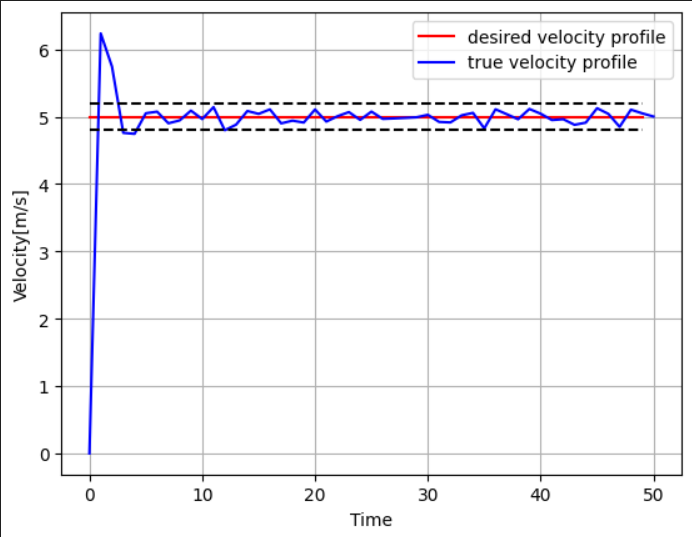
### Noise added. PD controller present. Still no integral controller.

## 8.2 Lateral Controller [6.0]

The goal of the lateral controller is to ensure that the steering angle $\delta$ is set such that the vehicle intersects the desired path at a look-ahead distance $l_d$ according to the pure-pursuit strategy explained in the lecture.

<img src="pure_pursuit.png" width="500">

Implement a lateral controller with $l_d = 2\,m$. The length of the car is $d = 1\,m$. Verify that your implementation is correct for some test input.

#### 1) I have added a function calc_alpha() in ex8.py to calculate the angle between robot's current heading and the line connecting the target point to the robot. This angle is then used to calculate the desired steering angle.
#### 2) I then added the function calc_delta() to calculate the desired steering angle based on the lookahead distance, the rear-front-wheel distance, and alpha.

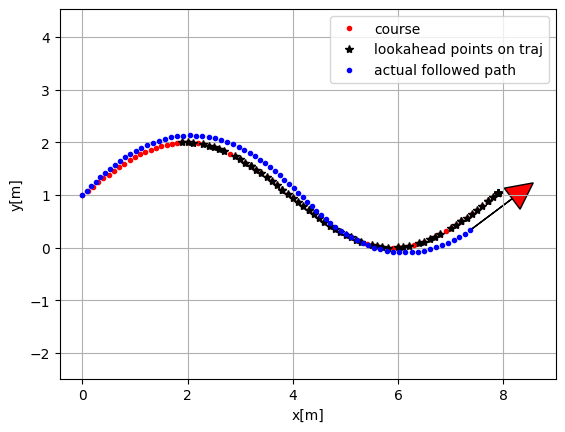

In [3]:
# Implement the lateral controller which sets the steering angle
# TODO: initialize robot

robot = ex.Robot()
robot.theta = np.pi/4
robot.v = 0.6
robot.delta = 0

lookx = []
looky = []

# TODO: define desired trajectory
xdes = list(np.arange(0, 8, 0.1))
ydes = [(np.sin(0.8*x_des) + 1) for x_des in xdes]

robot.x = xdes[0]
robot.y = ydes[0]

ground_truth_x = [robot.x]
ground_truth_y = [robot.y]

dt = 0.2

# TODO: compute the desired delta control 
for i in range(len(xdes)):
    
    ind = ex.calculate_lookahead_index(robot, xdes, ydes)
    lookx.append(xdes[ind])
    looky.append(ydes[ind])

    alpha = ex.calc_alpha(robot, lookx[i], looky[i])

    delta_des = ex.calc_delta(alpha)

    delta_dot = ex.lateral_controller(robot.delta, delta_des, dt, K_p=0.7, K_d=0, K_i=0)
    
    robot.apply_control(0, delta_dot, dt)

    ground_truth_x.append(robot.x)
    ground_truth_y.append(robot.y)

    if i==70: # had to do this because in the boundry, the while loop inside calculate_lookahead() runs infinitely
        break



# Plot desired trajectory and relevant results
ex.plot_arrow(robot.x, robot.y, robot.theta)
plt.plot(xdes, ydes, ".r", label="course")
plt.plot(lookx, looky, "*k", label="lookahead points on traj")
plt.plot(ground_truth_x, ground_truth_y, ".b", label = "actual followed path")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)
plt.show()

#### The best choice of controller for this problem seems to be a mere proportional.

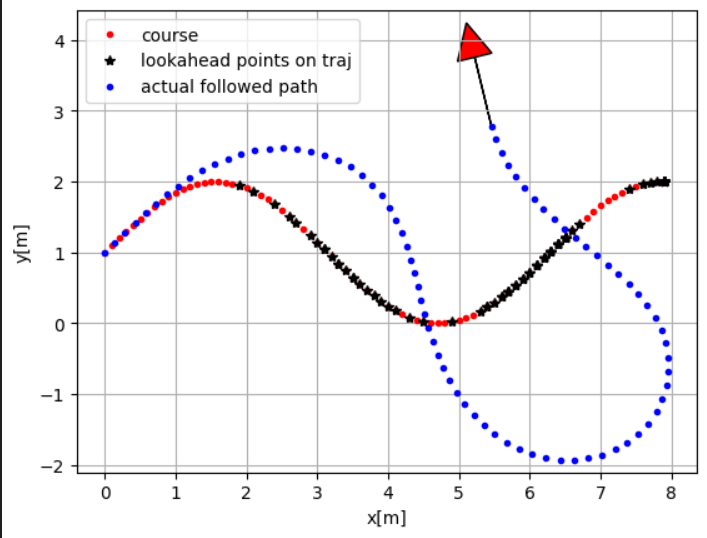
#### K_p=0.4, K_d=0, K_i=0, High Speed, Bigger Motion Steps
#### The motion steps are too coarse grained and the controller is too slow, it can't keep up.

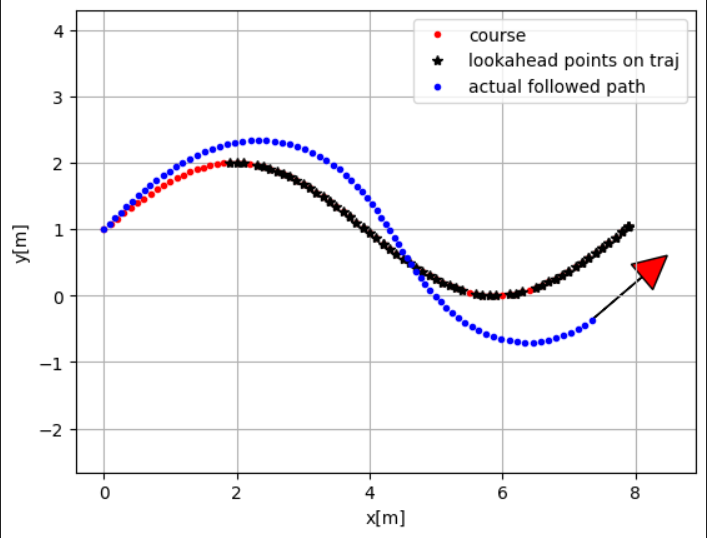
#### K_p=0.4, K_d=0, K_i=0 PID coefficients. Only the robot is slower this time, and thus has smaller motion steps. controller can adjust the motion in time.
#### All in all, the current system configuration, e.g. values of velocity, dt, lookahead distance, and the desired trajectory are within our controller's abilities. In case they are not, here are a few possible approaches that can be taken (confirmed via trial and error):
#### 1. Reduce the velocity or the time increment (equivalent to increasing the control frequency) so that either way the motion increments would decrease.
#### 2. Increase the Kp so that we'd have stronger control commands. Theoretically, we could increase Kp drastically but this is really non-advisable. Firstly, because in real-world control problems, Kp's above 1 are rarely used. Secondly, both in this problem and in real world scenarios, the magnitude of control command that the system can handle is limited. In this problem we have a limit of 60 degrees. In real life scenarios, even a steering angle of 60 degrees can cause the vehice to tip over at high enough vlocities.
#### 3. Plan a smoother and less curvy trajectory for the platform to follow. Avoid very small radii of curvature, i.e. sharp turns.
#### 4. Decrease the lookahead distance (at the cost of more fluctuation in path following and a less smooth ground-truth trajectory).

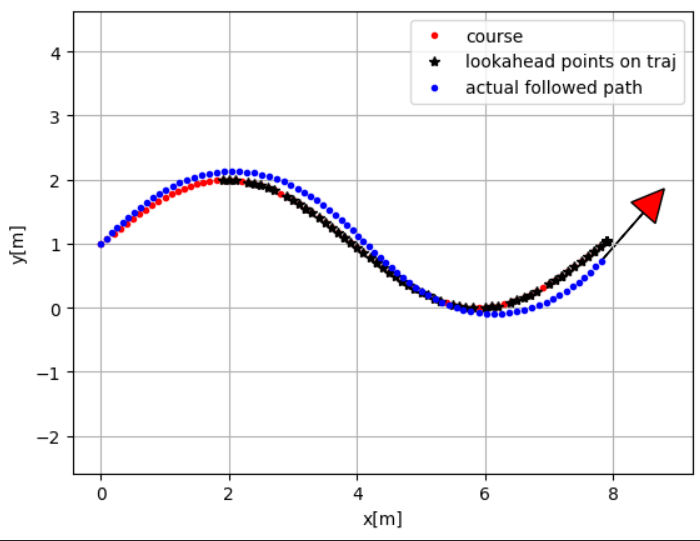
#### some of the above steps taken >> very accurate path following
#### so far, the starting heading of the robot was along the trajectory. Let's give it a considerable initial orientation wrt to the desired path, and see how it goes:

![fig 7.png](<attachment:fig 7.png>)
#### Kp = 0.7, Kd = Ki = 0, v = 0.55 m/s
#### The controller can catch up fairly promptly. Of course, we could use brute-force and just increase Kp.
#### 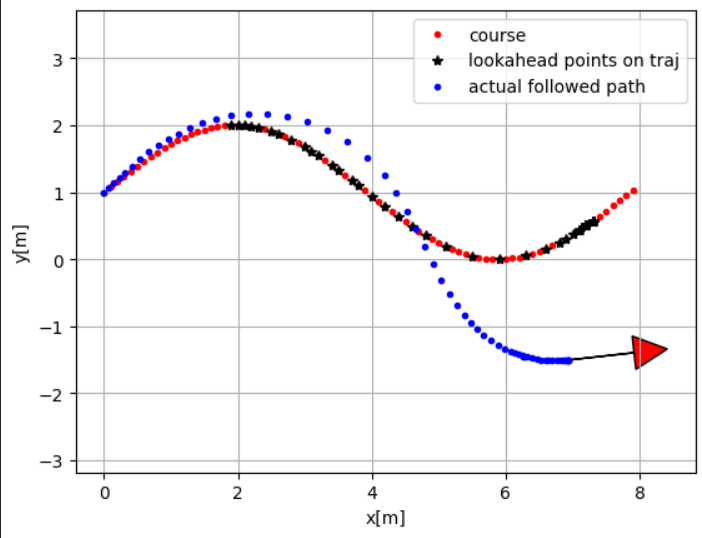
#### The figure above deals with some noisy control inputs (Noise parameter set to True) using a PI controller
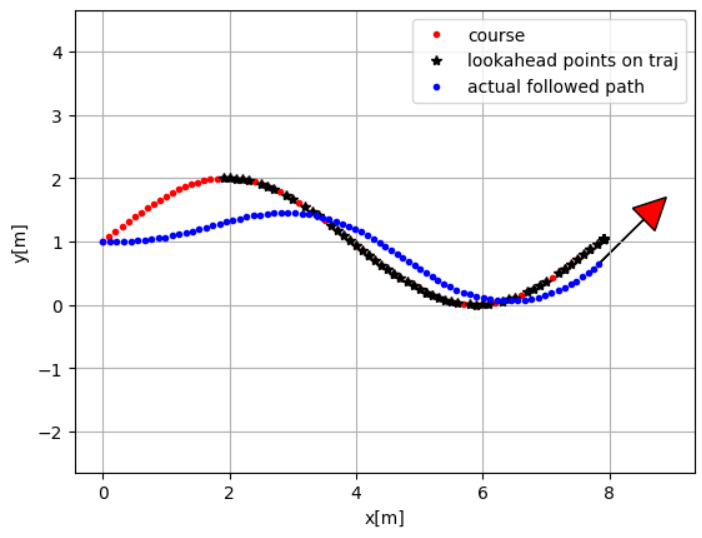

In [4]:
# TODO: If there's time, I'd like to test the longitudinal controller with only a single target point but multiple motion increments. We can then check to see whether the ...
# ... platform follows a circular, as it should according to pure pursuit.

## 8.3 Path Following Task [5.0]

Once you complete the above two functions, implement the procedure to follow the desired path as accurately as possible. The desired path to be followed is a curve provided in the code snippet. The desired linear velocity 
is $v_{des} = 2\,m/s$. The robot starts at an initial pose $x_0 = [0, 3, \pi/3]$.

Implement the function which uses the longitudinal and lateral controllers to follow the path. Run the simulation upto time T = 100 seconds or until the end of trajectory is reached. Assume that the controllers provide input at 10 Hz (i.e dt = 0.1). Plot the actual trajectory followed by the robot and overlay it with the desired trajectory.

Hints:
1. You may use the function `calculate_lookahead_index` to compute the index of the lookahead point along the trajectory. 
2. You may also play with the lookahead distance parameter $L_d$ to obtain better tracking results.

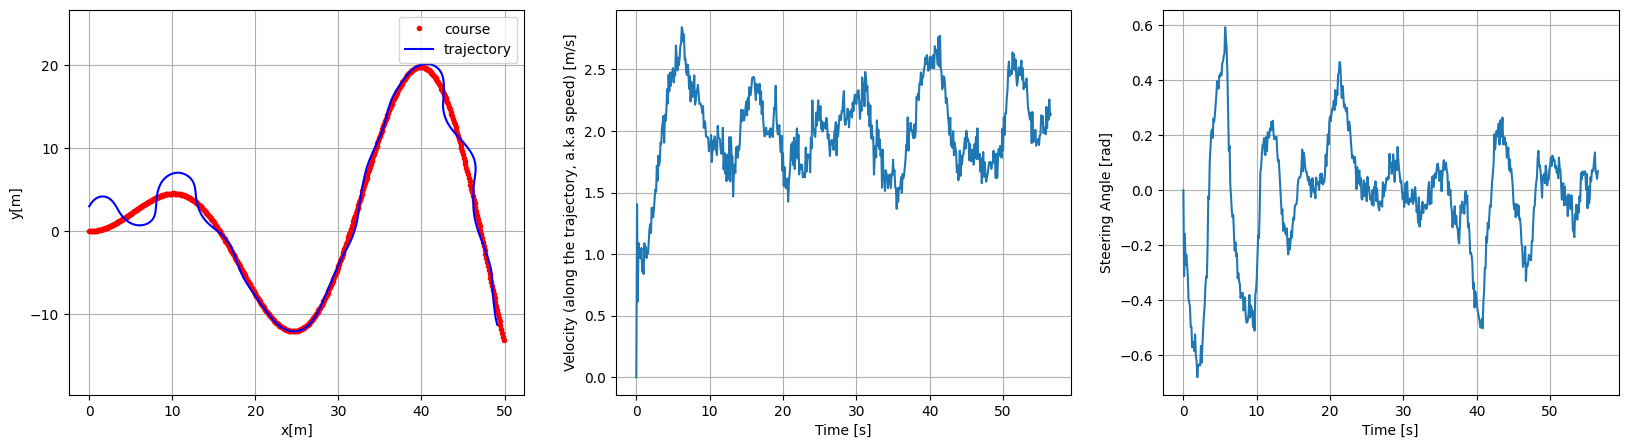

Velocity control parameters:
K Proportional velocity = 0.4
K Derivative velocity = 0.6
K Integral velocity = 0.5
Steering control parameters:
K Proportional steering = 0.7
K Derivative steering = 0.45
K Integral steering = 0


In [3]:
import ex8 as ex
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(42)

# Implement code to call the two implemented controllers to follow a dedired trajectory

# TODO: initialize robot
robot = ex.Robot()
robot.x = 0
robot.y = 3
robot.theta = np.pi/3
robot.v = 0

# TODO: desired longitudinal velocity 
v_des = 2

# desired trajectory
x_des = np.arange(0, 50, 0.1)
y_des = [math.sin(x_i / 5.0) * x_i / 2.0 for x_i in x_des]

lookx = []
looky = []

# variables to record robot state
x_traj = [robot.x]
y_traj = [robot.y]
theta_traj = [robot.theta]
v_t = [robot.v]
delta_t = [robot.delta]

# set simulation time
T = 100
dt = 0.1 # 10Hz
t = 0
t_vec_4_plotting = [t]

# Steering control coefficients
K_p, K_d, K_i = 0.7, 0.45, 0

i = 0
# main loop
while t < T:

    # TODO: compute control and update robot pose
    a_control = ex.longitudinal_controller(v_t[i], v_des, dt)
    
    ind = ex.calculate_lookahead_index(robot, x_des, y_des)
    lookx.append(x_des[ind])
    looky.append(y_des[ind])

    alpha = ex.calc_alpha(robot, lookx[i], looky[i])

    delta_des = ex.calc_delta(alpha)

    delta_dot = ex.lateral_controller(robot.delta, delta_des, dt, K_p, K_d, K_i)
    
    robot.apply_control(a_control, delta_dot, dt)
    
    # update time
    t = t + dt
    
    # save varaibles for plotting
    x_traj.append(robot.x)
    y_traj.append(robot.y)
    theta_traj.append(robot.theta)
    v_t.append(robot.v)
    delta_t.append(robot.delta)

    # updating the time vector for plotting variables separately against time
    t_vec_4_plotting.append(t)

    # print(i)
    i += 1

    if i==565:
        break
    
# Plot trajectory
plt.figure(figsize=(20, 5))    

plt.subplot(1, 3, 1)
# plt.cla()
plt.plot(x_des, y_des, ".r", label="course")
plt.plot(x_traj, y_traj, "-b", label="trajectory")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(t_vec_4_plotting, v_t)
plt.xlabel("Time [s]")
plt.ylabel("Velocity (along the trajectory, a.k.a speed) [m/s]")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(t_vec_4_plotting, delta_t)
plt.xlabel("Time [s]")
plt.ylabel("Steering Angle [rad]")
plt.grid(True)

plt.show()

print("Velocity control parameters:", f"K Proportional velocity = {ex.Kp_velocity}", f"K Derivative velocity = {ex.Kd_velocity}", f"K Integral velocity = {ex.Ki_velocity}",\
      "Steering control parameters:", f"K Proportional steering = {K_p}", f"K Derivative steering = {K_d}", f"K Integral steering = {K_i}", sep='\n')

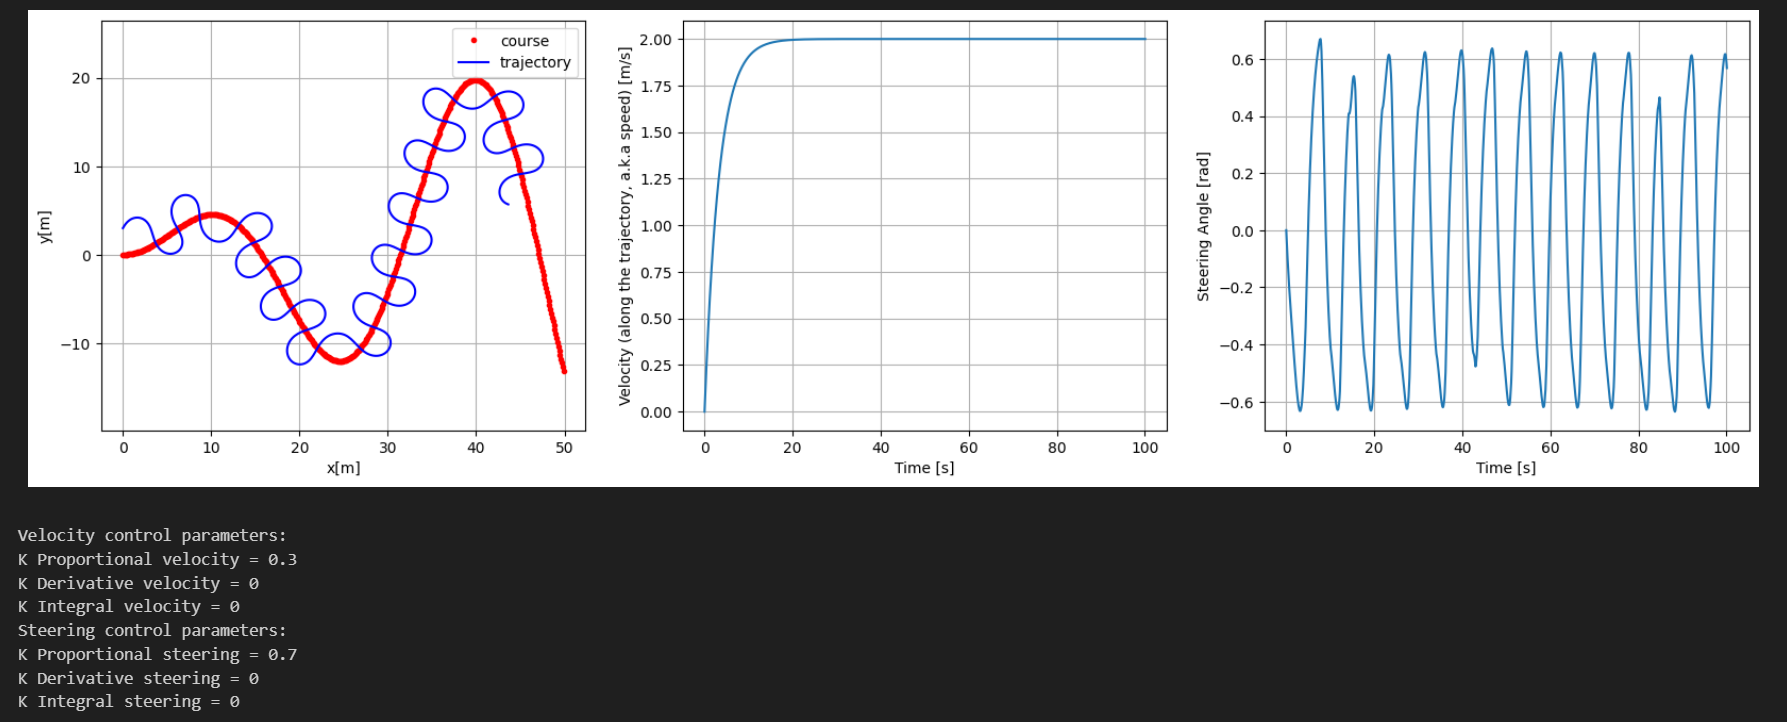
#### Cute trajectory! Let's improve it

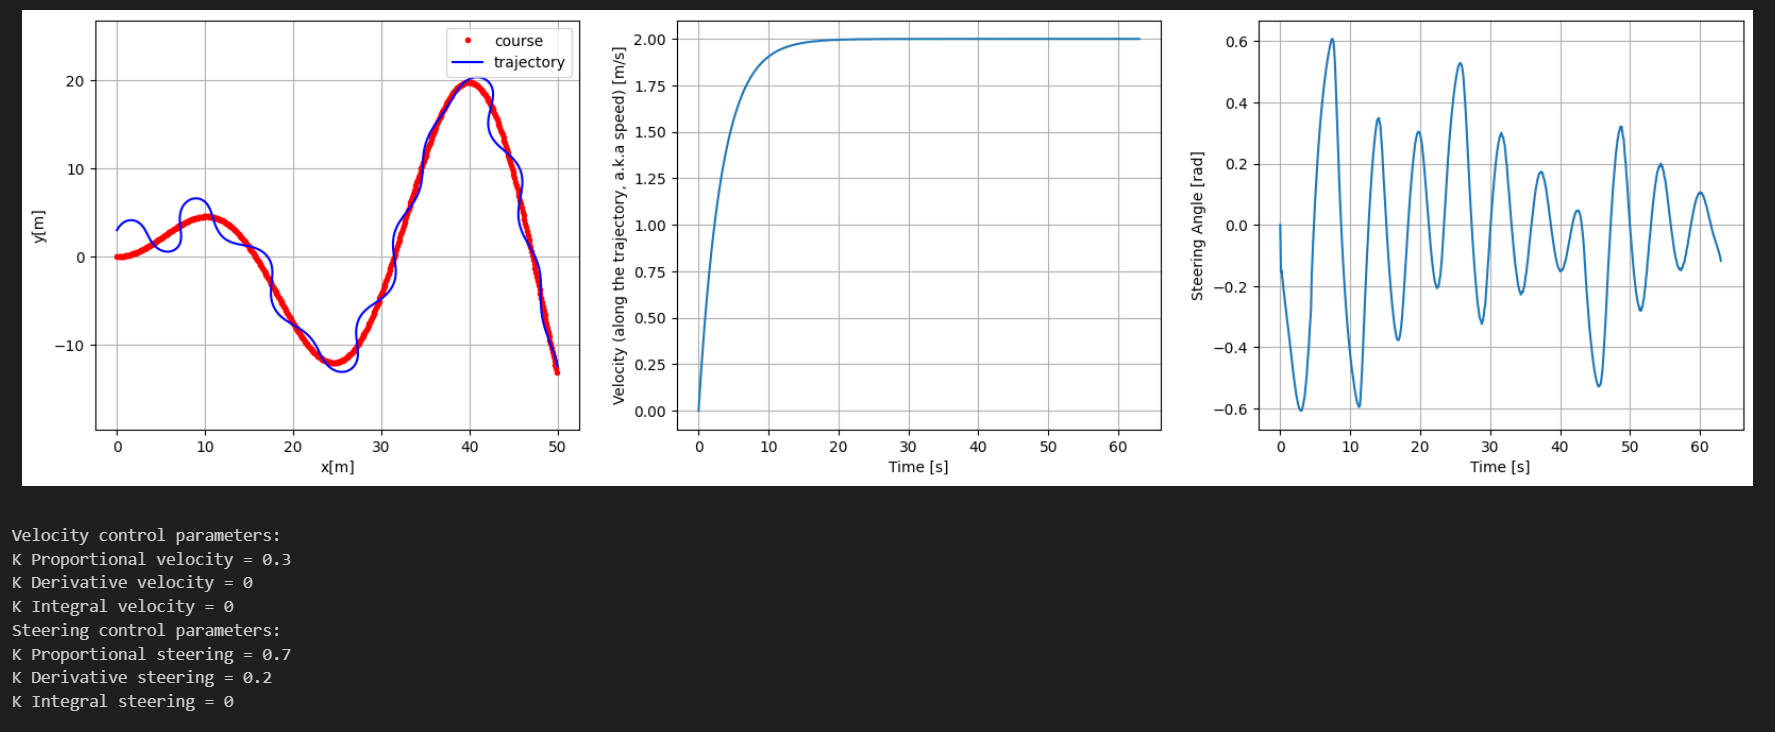
#### There's just one problem (or not! depending on what we define a problem). The platform reaches the end of the planned trajectory long before t = 100s. It does so at around t = 64 s. That's why I had to break the for loop at the time step that corresponds to t=63s. This action was called for because the calculate_lookahead_index() doesn't account for when the robot reaches near the endpoints of the trajectory and thus the while loop inside the function runs infinitely.

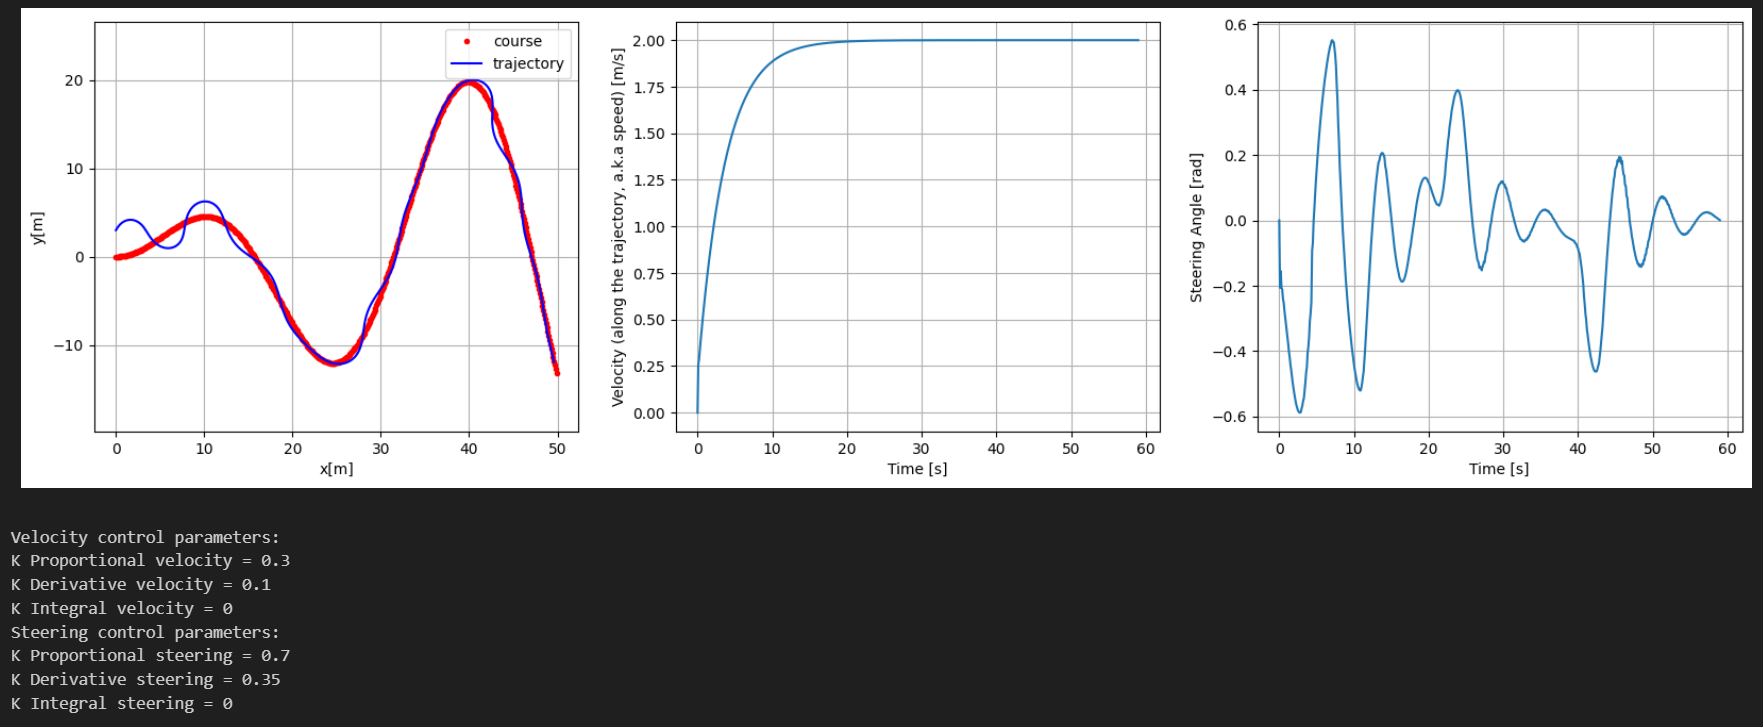

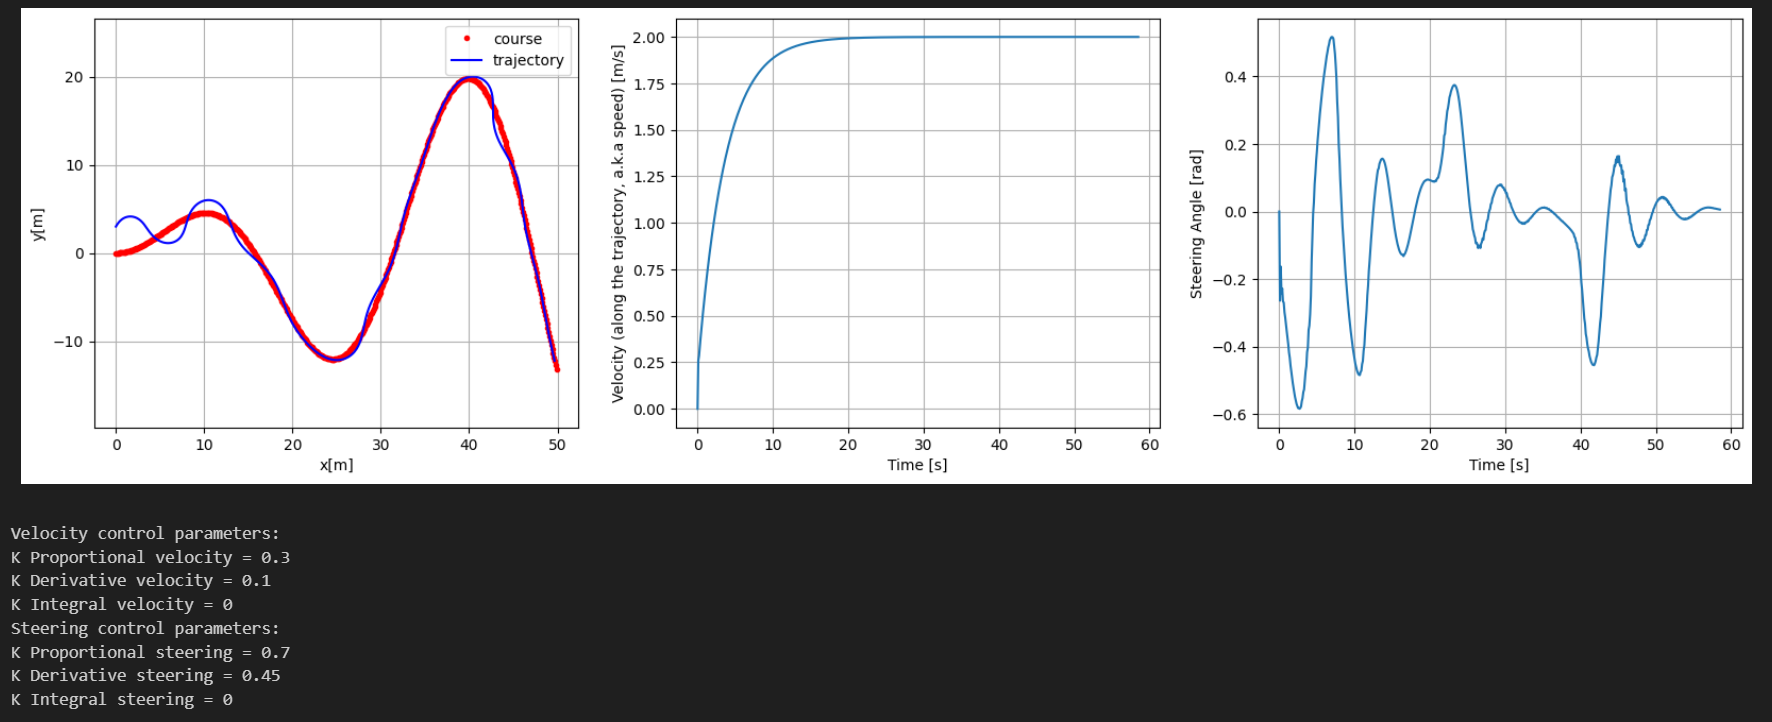
#### Also interesting to notice that as the controller becomes better (more prompt), the trajectory is followed faster. So that there's less wasted traveled distance. Such that in the last case, where the traveled and the planned trajectories overlap the most, the platform finishes the trajectory uder 60 seconds (as compared to 64 seconds in the previous case). This time I had to end the loop at around t = 58s.

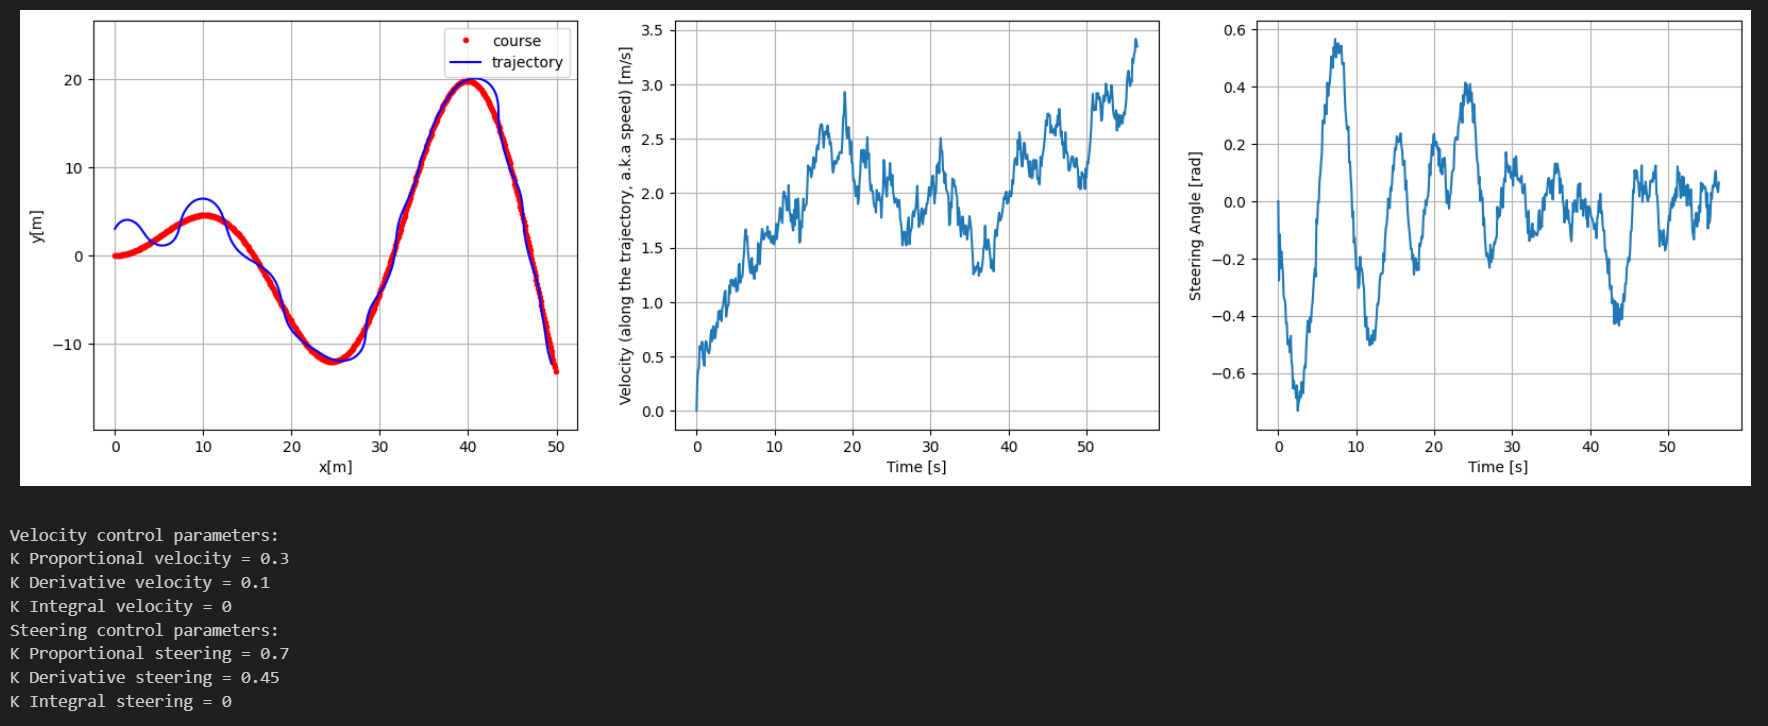
#### Random noise added to control (Noise = True). The velocity control doesn't look good.

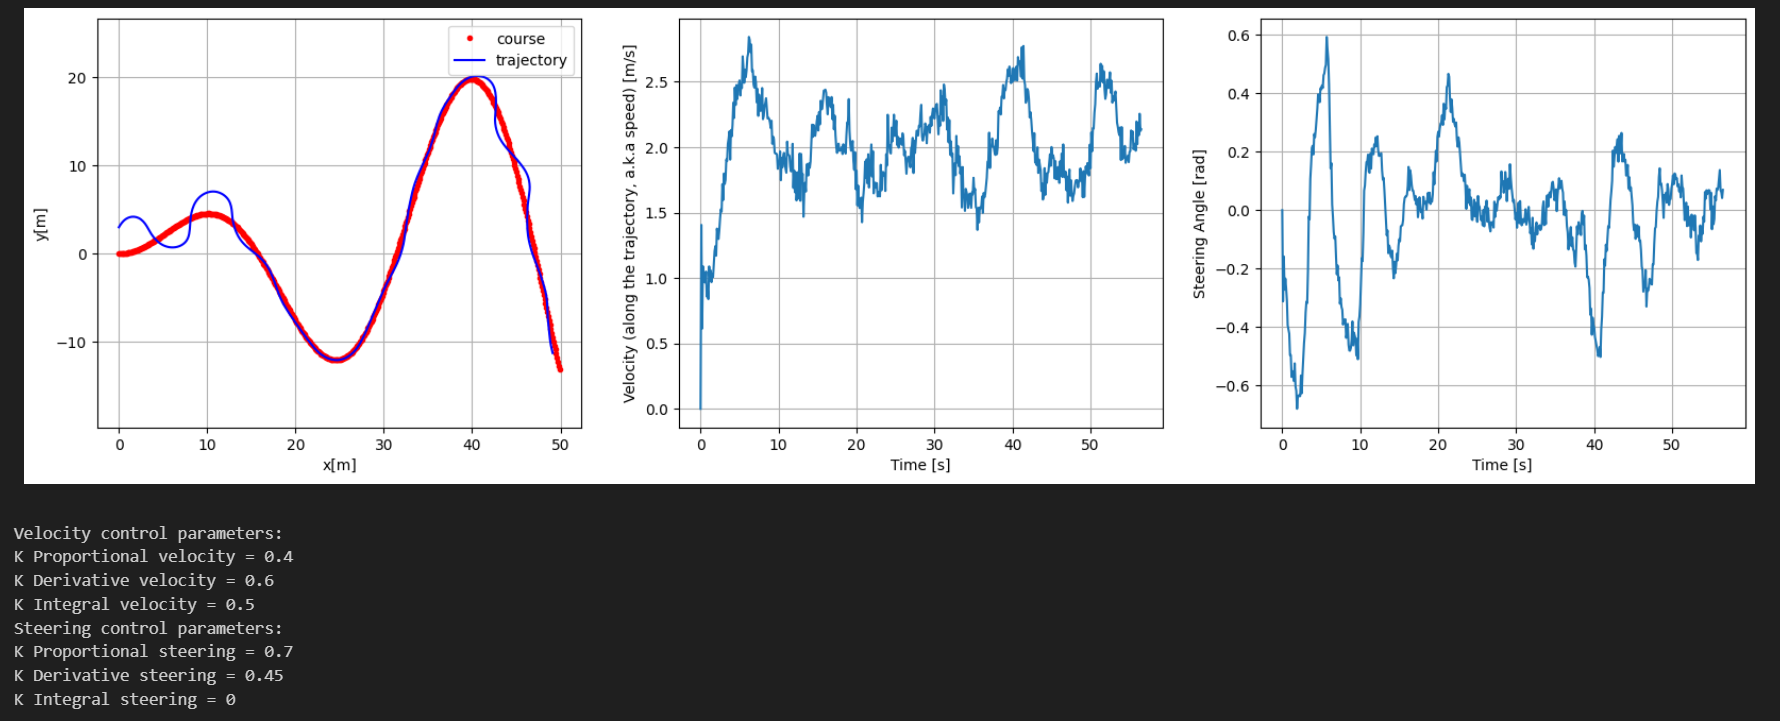
#### At least now its fluctuating around the desired value instead of going haywire!

## 8.4 Unfeasible Trajectory [3.0]

The desired trajectory of the preiovus exercise is not feasible due to the robot's constraints. Imagine that you can get a second robot, identical to the first one, but with different constraints. Define new limits for $v$, $|\delta|$ and $|\dot{\delta}|$, such as this robot can follow the desired trajectory and show the result.
Confusion: Our robot is already following the desired trajectory. So this task is pretty much repeating the prevoius task. Only the delta_max and the v_max values have been relaxed to 2*pi/3 rad and 30 m/s respectively.

_Hint:_ Use the previous code and try to change one limit at the time.

Please note that for this part, the ex8.py file is going through even more changes than before. So if you run the above cells with the current (most recent) ex8.py file, you will not get the same results. Best abstain from doing that and kindly evaluate our results as they have already been obtained in the current jupyter notebook.

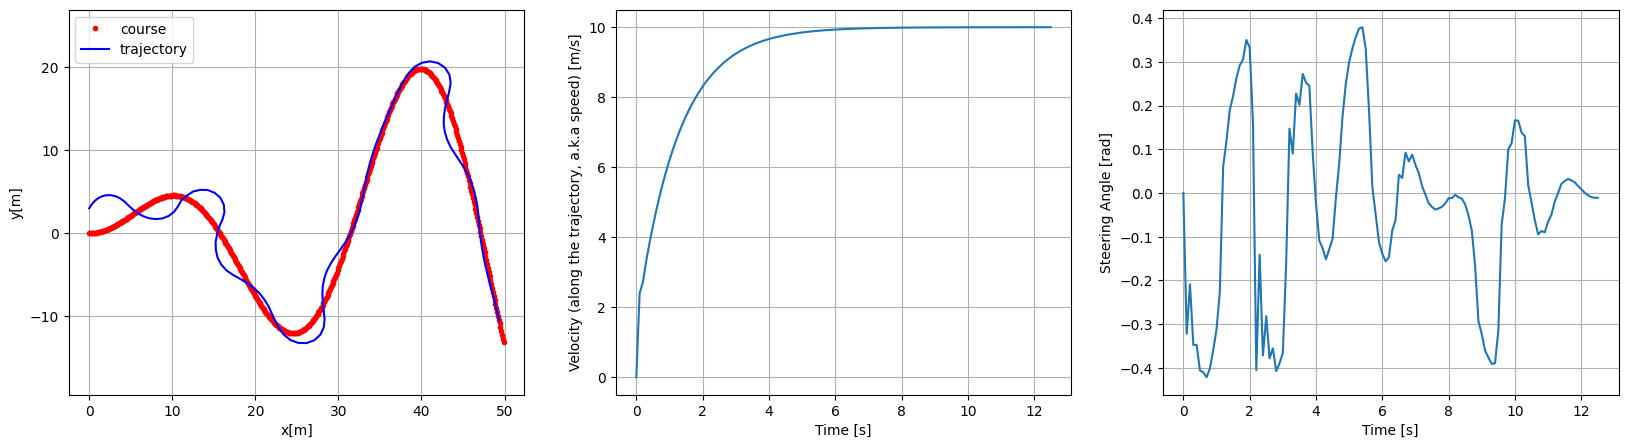

Velocity control parameters:
K Proportional velocity = 0.9
K Derivative velocity = 0.15
K Integral velocity = 0
Steering control parameters:
K Proportional steering = 0.8
K Derivative steering = 0.55
K Integral steering = 0.4


In [1]:
import ex8 as ex
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(42)

# Implement code to call the two implemented controllers to follow a dedired trajectory

# TODO: initialize robot
robot = ex.Robot()
robot.x = 0
robot.y = 3
robot.theta = np.pi/3
robot.v = 0

# TODO: desired longitudinal velocity 
v_des = 10

# TODO: define new constraints
# v_max = ...
# delta_max = ... 
# delta_dot_max = ...

# desired trajectory
x_des = np.arange(0, 50, 0.1)
y_des = [math.sin(x_i / 5.0) * x_i / 2.0 for x_i in x_des]

# variables to record robot state
x_traj = [robot.x]
y_traj = [robot.y]
theta_traj = [robot.theta]
v_t = [robot.v]
delta_t = [robot.delta]

lookx = []
looky = []

# set simulation time
T = 100
dt = 0.1 # 10Hz
t = 0
t_vec_4_plotting = [t]

# Steering control coefficients
K_p, K_d, K_i = 0.8, 0.55, 0.4

i = 0
# main loop
while t < T:

    # TODO: compute control and update robot pose
    a_control = ex.longitudinal_controller(v_t[i], v_des, dt)
    
    ind = ex.calculate_lookahead_index(robot, x_des, y_des)
    lookx.append(x_des[ind])
    looky.append(y_des[ind])

    alpha = ex.calc_alpha(robot, lookx[i], looky[i])

    delta_des = ex.calc_delta(alpha)

    delta_dot = ex.lateral_controller(robot.delta, delta_des, dt, K_p, K_d, K_i)
    
    robot.apply_control(a_control, delta_dot, dt)
    
    # update time
    t = t + dt
    
    # save varaibles for plotting
    x_traj.append(robot.x)
    y_traj.append(robot.y)
    theta_traj.append(robot.theta)
    v_t.append(robot.v)
    delta_t.append(robot.delta)

    # updating the time vector for plotting variables separately against time
    t_vec_4_plotting.append(t)

    # print(i)
    i += 1

    if i==125:
        break
    
# Plot trajectory
plt.figure(figsize=(20, 5))    

plt.subplot(1, 3, 1)
# plt.cla()
plt.plot(x_des, y_des, ".r", label="course")
plt.plot(x_traj, y_traj, "-b", label="trajectory")
plt.legend()
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.axis("equal")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(t_vec_4_plotting, v_t)
plt.xlabel("Time [s]")
plt.ylabel("Velocity (along the trajectory, a.k.a speed) [m/s]")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(t_vec_4_plotting, delta_t)
plt.xlabel("Time [s]")
plt.ylabel("Steering Angle [rad]")
plt.grid(True)

plt.show()

print("Velocity control parameters:", f"K Proportional velocity = {ex.Kp_velocity}", f"K Derivative velocity = {ex.Kd_velocity}", f"K Integral velocity = {ex.Ki_velocity}",\
      "Steering control parameters:", f"K Proportional steering = {K_p}", f"K Derivative steering = {K_d}", f"K Integral steering = {K_i}", sep='\n')